In [82]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR


In [83]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='BENDING', folder='CONSTANT_THICKNESS_100', length=100)
df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,23.835890,28.542961,2.50,2.15,1.63,75.95,127.83,263.44,66771.2
1,25.324615,30.559906,2.83,2.02,1.44,75.76,127.25,246.66,69501.7
2,25.165036,29.325711,2.85,1.78,1.44,76.51,127.53,243.62,65759.5
3,24.157056,28.547982,2.71,1.72,1.51,75.41,127.61,258.13,65259.4
4,24.802531,28.899586,2.67,1.74,1.65,76.22,128.53,261.38,65053.8


In [84]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
#Y = df[['max_force', 'mean_force']]
Y = df[['max_force']].values

In [85]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [86]:
SVR_model =SVR(kernel='rbf',C=100,gamma= 0.1)
SVR_model.fit(X_train,Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [87]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.6159730


In [88]:
RBF_model = RBF(d0=500)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0017481
      Initializing linear solver - done. Time (sec):  0.0018718
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0002036
      Solving linear system (col. 0) - done. Time (sec):  0.0002389
   Training - done. Time (sec):  0.0071781


In [100]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/500
3/3 [==============================] - 0s 51ms/step - loss: 930.3382 - val_loss: 886.6473
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 904.4042 - val_loss: 855.4754
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 867.9941 - val_loss: 809.7529
Epoch 4/500
3/3 [==============================] - 0s 8ms/step - loss: 814.8065 - val_loss: 740.5628
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 732.5281 - val_loss: 637.4012
Epoch 6/500
3/3 [==============================] - 0s 8ms/step - loss: 612.8912 - val_loss: 490.0119
Epoch 7/500
3/3 [==============================] - 0s 10ms/step - loss: 445.7420 - val_loss: 299.3840
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 242.4430 - val_loss: 102.6730
Epoch 9/500
3/3 [==============================] - 0s 8ms/step - loss: 64.4952 - val_loss: 14.4261
Epoch 10/500
3/3 [==============================] - 0s 7ms/step - loss: 47.1636 - val_loss:

In [101]:
Y_predicted_KRG = KRG_model.predict_values(X_val)
Y_predicted_RBF = RBF_model.predict_values(X_val)
Y_predicted_SVR = SVR_model.predict(X_val)
Y_predicted_ANN = model.predict(X_val)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0072827
   
   Prediction time/pt. (sec) :  0.0003641
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0001500
   
   Prediction time/pt. (sec) :  0.0000075
   
1/1 [==============================] - 0s 77ms/step


In [98]:
print("MSE, for KRG:", mean_squared_error(Y_val, Y_predicted_KRG))
print("MSE, for RBF:", mean_squared_error(Y_val, Y_predicted_RBF))
print("MSE, for SVR:", mean_squared_error(Y_val, Y_predicted_SVR))
print("MSE, for ANN:", mean_squared_error(Y_val, Y_predicted_ANN))

MSE, for KRG: 0.032577580826512506
MSE, for RBF: 0.011681439943421997
MSE, for SVR: 0.019197053289372927
MSE, for ANN: 0.17248331514548565


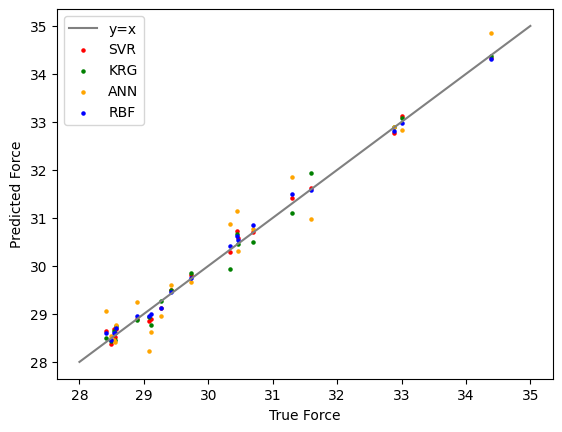

In [95]:
plt.plot([28, 35], [28, 35], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True Force')
plt.ylabel('Predicted Force')
plt.legend()